In [1]:
import numpy as np
import jax.numpy as jnp
import jax.scipy as jsp
import matplotlib.pyplot as plt

from jax import random, jit, value_and_grad
from jax.config import config
from scipy.optimize import minimize

config.update("jax_enable_x64", True)
%matplotlib inline

In [2]:
def func(x):
    """Latent function."""
    return 1.0 * jnp.sin(x * 3 * jnp.pi) + \
           0.3 * jnp.cos(x * 9 * jnp.pi) + \
           0.5 * jnp.sin(x * 7 * jnp.pi)


# Number of training examples
n = 1000

# Number of inducing variables
m = 30

# Noise
sigma_y = 0.2

# Noisy training data
X = jnp.linspace(-1.0, 1.0, n).reshape(-1, 1)
y = func(X) + sigma_y * random.normal(random.PRNGKey(0), shape=(n, 1))

# Test data
X_test = np.linspace(-1.5, 1.5, 1000).reshape(-1, 1)
f_true = func(X_test)

# Inducing inputs
X_m = jnp.linspace(-0.4, 0.4, m).reshape(-1, 1)

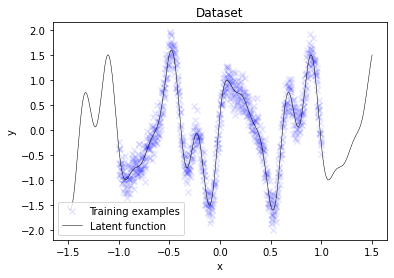

In [3]:
plt.scatter(X, y, label='Training examples', marker='x', color='blue', alpha=0.1)
plt.plot(X_test, f_true, label='Latent function', c='k', lw=0.5)
plt.title('Dataset')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

In [4]:
from models import FCN
from neural_tangents import stax
from snngp import SNNGP

model = FCN
model_params = dict(
    nonlinearity=stax.Erf
)

snngp = SNNGP(model=model, hyper_params=model_params, train_data=(X, y), inducing_points=X_m, num_latent_gps=1)

snngp.lower_bound(), snngp.upper_bound(), snngp.evaluate()

(DeviceArray(-1264.75594335, dtype=float64),
 DeviceArray(-1135.12660885, dtype=float64),
 DeviceArray(129.6293345, dtype=float64))

In [5]:
opt_params = snngp.optimize()
snngp.lower_bound(), snngp.upper_bound(), snngp.evaluate()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           32     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.26476D+03    |proj g|=  2.64327D+01

At iterate    1    f=  1.08341D+03    |proj g|=  1.72247D+02

At iterate    2    f=  1.04448D+03    |proj g|=  7.16037D+02

At iterate    3    f=  1.03286D+03    |proj g|=  3.27162D+01

At iterate    4    f=  1.03234D+03    |proj g|=  6.49026D+01

At iterate    5    f=  1.03187D+03    |proj g|=  1.74028D+01

At iterate    6    f=  1.03119D+03    |proj g|=  1.65435D+01

At iterate    7    f=  1.02794D+03    |proj g|=  4.95990D+01

At iterate    8    f=  1.02636D+03    |proj g|=  1.31338D+01


 This problem is unconstrained.



At iterate    9    f=  1.02545D+03    |proj g|=  1.30420D+01

At iterate   10    f=  1.02412D+03    |proj g|=  1.32887D+01

At iterate   11    f=  1.02227D+03    |proj g|=  1.35521D+01

At iterate   12    f=  1.02127D+03    |proj g|=  1.55972D+01

At iterate   13    f=  1.01976D+03    |proj g|=  8.52953D+00

At iterate   14    f=  1.01888D+03    |proj g|=  1.15119D+01

At iterate   15    f=  1.01659D+03    |proj g|=  1.55077D+01

At iterate   16    f=  1.01635D+03    |proj g|=  1.59899D+01

At iterate   17    f=  1.01570D+03    |proj g|=  1.06215D+01

At iterate   18    f=  1.01535D+03    |proj g|=  1.42815D+01

At iterate   19    f=  1.01477D+03    |proj g|=  1.18023D+01

At iterate   20    f=  1.01447D+03    |proj g|=  4.87068D+00

At iterate   21    f=  1.01420D+03    |proj g|=  4.68980D+00

At iterate   22    f=  1.01403D+03    |proj g|=  6.03193D+00

At iterate   23    f=  1.01384D+03    |proj g|=  4.06152D+00

At iterate   24    f=  1.01355D+03    |proj g|=  6.86713D+00

At iter

(DeviceArray(-997.9920005, dtype=float64),
 DeviceArray(-979.03893246, dtype=float64),
 DeviceArray(18.95306804, dtype=float64))

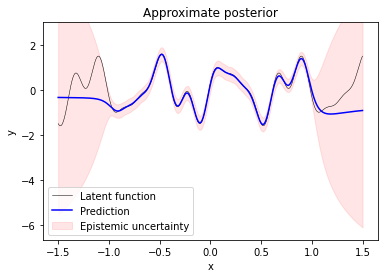

In [6]:
f_test, f_test_cov = snngp.predict(X_test, diag=True)
# f_test_var = np.diag(f_test_cov)
# f_test_std = np.sqrt(f_test_var)
f_test_std = np.sqrt(f_test_cov)

plt.plot(X_test, f_true, label='Latent function', c='k', lw=0.5)
plt.plot(X_test, f_test, label='Prediction', c='b')
plt.fill_between(X_test.ravel(), 
                 f_test.ravel() + 2 * f_test_std.ravel(), 
                 f_test.ravel() - 2 * f_test_std.ravel(),
                 label='Epistemic uncertainty',
                 color='r', alpha=0.1)
plt.title('Approximate posterior')
plt.xlabel('x')
plt.ylabel('y')
plt.ylim(None, 3.0)
plt.legend()

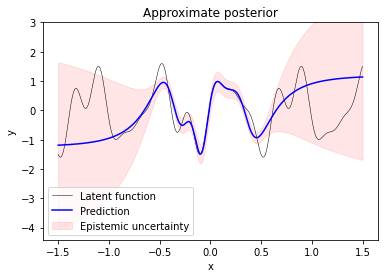

In [7]:
# f_test, f_test_cov = snngp.predict1(X_test, opt_params)
# f_test_var = np.diag(f_test_cov)
# f_test_std = np.sqrt(f_test_var)

# plt.plot(X_test, f_true, label='Latent function', c='k', lw=0.5)
# plt.plot(X_test, f_test, label='Prediction', c='b')
# plt.fill_between(X_test.ravel(), 
#                  f_test.ravel() + 2 * f_test_std, 
#                  f_test.ravel() - 2 * f_test_std,
#                  label='Epistemic uncertainty',
#                  color='r', alpha=0.1)
# plt.title('Approximate posterior')
# plt.xlabel('x')
# plt.ylabel('y')
# plt.ylim(None, 3.0)
# plt.legend()

In [9]:
var = np.array([[1,2],[3,4]])
var1 = var[None, ...]
var1 = np.tile(var1, [3, 1, 1])
var, var1

(array([[1, 2],
        [3, 4]]),
 array([[[1, 2],
         [3, 4]],
 
        [[1, 2],
         [3, 4]],
 
        [[1, 2],
         [3, 4]]]))

In [10]:
var.shape, var[None, ...].shape, var1.shape

((2, 2), (1, 2, 2), (3, 2, 2))

In [14]:
np.diag(var)[:, None].shape, np.tile(np.diag(var)[:, None], [1, 3]).shape

((2, 1), (2, 3))